# Gold Price Prediction with Sentiment Data and Macroeconomic indicators

In [82]:
# importing all the required library
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

In [83]:
# import the require dataset for the analysis
gold_data = pd.read_csv('result_Data\gold_dataset.csv')
sentiment_data = pd.read_csv('result_Data\sentiment_dataset.csv')
additional_features = pd.read_csv('result_Data/additional_features.csv')

In [84]:
# first few record in the dataset
gold_data.head()

,date,gold_price
0,2015-01-02,1186.2
1,2015-01-05,1204.0
2,2015-01-06,1219.4
3,2015-01-07,1210.7
4,2015-01-08,1208.5


In [85]:
gold_data.shape

(2499, 2)

In [86]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        2499 non-null   object 
 1   gold_price  2499 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.2+ KB


In [87]:
# first few record in the dataset
sentiment_data.head()

,date,sentiment_score
0,2015-01-02,-0.4019
1,2015-01-05,0.4404
2,2015-01-07,-0.5106
3,2015-01-09,0.0000
4,2015-01-12,0.0000


In [88]:
sentiment_data.shape

(1539, 2)

In [89]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1539 non-null   object 
 1   sentiment_score  1539 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.2+ KB


In [90]:
# first few record in the dataset
additional_features.head()

,date,usd_rate,oil_price,bond_yield_price,interest_rate,inflation_rate
0,2015-01-02,91.08,52.69,2.114,0.12,1.71
1,2015-01-05,91.38,50.04,2.034,0.12,1.64
2,2015-01-06,91.50,47.93,1.938,0.12,1.56
3,2015-01-07,91.89,48.65,1.969,0.12,1.57
4,2015-01-08,92.37,48.79,2.018,0.12,1.62


In [91]:
additional_features.shape

(2429, 6)

In [92]:
additional_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2429 non-null   object 
 1   usd_rate          2429 non-null   float64
 2   oil_price         2429 non-null   float64
 3   bond_yield_price  2429 non-null   float64
 4   interest_rate     2429 non-null   float64
 5   inflation_rate    2429 non-null   float64
dtypes: float64(5), object(1)
memory usage: 114.0+ KB


In [93]:
# function to change the date data type from object to date
def changeDataType(df):
    df['date']=pd.to_datetime(df['date'])
    return df

In [94]:
# apply date datatype change function
gold_data = changeDataType(gold_data)
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2499 non-null   datetime64[ns]
 1   gold_price  2499 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.2 KB


In [95]:
# apply date datatype change function
sentiment_data = changeDataType(sentiment_data)
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1539 non-null   datetime64[ns]
 1   sentiment_score  1539 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.2 KB


In [96]:
# apply date datatype change function
additional_features = changeDataType(additional_features)
additional_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2429 non-null   datetime64[ns]
 1   usd_rate          2429 non-null   float64       
 2   oil_price         2429 non-null   float64       
 3   bond_yield_price  2429 non-null   float64       
 4   interest_rate     2429 non-null   float64       
 5   inflation_rate    2429 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 114.0 KB


In [97]:
# date range in consideration for the analysis
# all_dates = pd.date_range(start='2010-01-01', end='2024-10-16', freq='D')
all_dates = pd.date_range(start='2015-01-01', end='2024-10-16', freq='D')

In [98]:
# applying the data range on the sentiment data 
sentiment_data = sentiment_data.set_index('date').reindex(all_dates).rename_axis('date').reset_index()
sentiment_data.head()

,date,sentiment_score
0,2015-01-01,NaN
1,2015-01-02,-0.4019
2,2015-01-03,NaN
3,2015-01-04,NaN
4,2015-01-05,0.4404


In [99]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577 entries, 0 to 3576
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3577 non-null   datetime64[ns]
 1   sentiment_score  1539 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 56.0 KB


In [100]:
# Filter out weekends (Saturday=5, Sunday=6)
sentiment_data = sentiment_data[~sentiment_data['date'].dt.dayofweek.isin([5, 6])]
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 3576
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2555 non-null   datetime64[ns]
 1   sentiment_score  1233 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 59.9 KB


In [101]:
# combining the sentiment dataset and the additional features
combine_dataset = pd.merge(sentiment_data, additional_features, on='date', how='left')
combine_dataset.shape

(2555, 7)

In [102]:
# combined dataset
combine_dataset.head()

,date,sentiment_score,usd_rate,oil_price,bond_yield_price,interest_rate,inflation_rate
0,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,-0.4019,91.08,52.69,2.114,0.12,1.71
2,2015-01-05,0.4404,91.38,50.04,2.034,0.12,1.64
3,2015-01-06,NaN,91.50,47.93,1.938,0.12,1.56
4,2015-01-07,-0.5106,91.89,48.65,1.969,0.12,1.57


In [103]:
# combining the combine dataset with the gold dataset
combine_dataset = pd.merge(combine_dataset, gold_data, on='date', how='left')
combine_dataset.shape

(2555, 8)

In [104]:
combine_dataset.head()

,date,sentiment_score,usd_rate,oil_price,bond_yield_price,interest_rate,inflation_rate,gold_price
0,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,-0.4019,91.08,52.69,2.114,0.12,1.71,1186.2
2,2015-01-05,0.4404,91.38,50.04,2.034,0.12,1.64,1204.0
3,2015-01-06,NaN,91.50,47.93,1.938,0.12,1.56,1219.4
4,2015-01-07,-0.5106,91.89,48.65,1.969,0.12,1.57,1210.7


### Feature Engineering
* Create lag features of the gold price for 1 day and 5 days after the news date

In [106]:
# creating a lag variable for the gold price to create gold price after 1 day
combine_dataset['gold_price_after_1_day'] = combine_dataset['gold_price'].shift(-1)
combine_dataset.head()

,date,sentiment_score,usd_rate,oil_price,bond_yield_price,interest_rate,inflation_rate,gold_price,gold_price_after_1_day
0,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1186.2
1,2015-01-02,-0.4019,91.08,52.69,2.114,0.12,1.71,1186.2,1204.0
2,2015-01-05,0.4404,91.38,50.04,2.034,0.12,1.64,1204.0,1219.4
3,2015-01-06,NaN,91.50,47.93,1.938,0.12,1.56,1219.4,1210.7
4,2015-01-07,-0.5106,91.89,48.65,1.969,0.12,1.57,1210.7,1208.5


In [107]:
combine_dataset.isnull().sum()

date                         0
sentiment_score           1322
usd_rate                   126
oil_price                  126
bond_yield_price           126
interest_rate              126
inflation_rate             126
gold_price                  56
gold_price_after_1_day      56
dtype: int64

In [108]:
combine_dataset.dropna(subset=['sentiment_score','gold_price','usd_rate'], inplace=True)
combine_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1173 entries, 1 to 2534
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1173 non-null   datetime64[ns]
 1   sentiment_score         1173 non-null   float64       
 2   usd_rate                1173 non-null   float64       
 3   oil_price               1173 non-null   float64       
 4   bond_yield_price        1173 non-null   float64       
 5   interest_rate           1173 non-null   float64       
 6   inflation_rate          1173 non-null   float64       
 7   gold_price              1173 non-null   float64       
 8   gold_price_after_1_day  1155 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 91.6 KB


In [109]:
# filling the null values in gold_price_after_1_day and Gold_price_after_5_day with interpolation value
combine_dataset['gold_price_after_1_day'] = combine_dataset['gold_price_after_1_day'].interpolate()
combine_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1173 entries, 1 to 2534
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1173 non-null   datetime64[ns]
 1   sentiment_score         1173 non-null   float64       
 2   usd_rate                1173 non-null   float64       
 3   oil_price               1173 non-null   float64       
 4   bond_yield_price        1173 non-null   float64       
 5   interest_rate           1173 non-null   float64       
 6   inflation_rate          1173 non-null   float64       
 7   gold_price              1173 non-null   float64       
 8   gold_price_after_1_day  1173 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 91.6 KB


In [110]:
combine_dataset.head()

,date,sentiment_score,usd_rate,oil_price,bond_yield_price,interest_rate,inflation_rate,gold_price,gold_price_after_1_day
1,2015-01-02,-0.4019,91.08,52.69,2.114,0.12,1.71,1186.2,1204.0
2,2015-01-05,0.4404,91.38,50.04,2.034,0.12,1.64,1204.0,1219.4
4,2015-01-07,-0.5106,91.89,48.65,1.969,0.12,1.57,1210.7,1208.5
6,2015-01-09,0.0000,91.94,48.36,1.950,0.12,1.62,1216.1,1232.8
7,2015-01-12,0.0000,91.98,46.07,1.909,0.12,1.57,1232.8,1234.4


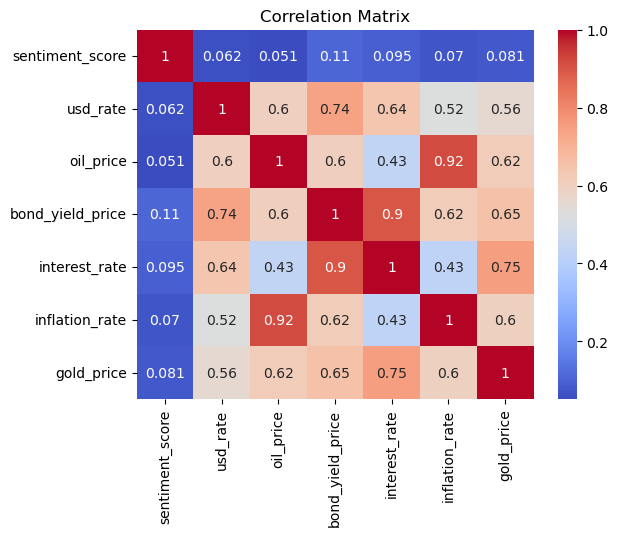

In [111]:
# Calculate the correlation matrix
corr_matrix = combine_dataset.drop(columns=['date','gold_price_after_1_day']).corr()

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [112]:
combine_dataset.to_csv('result_Data/mixed_dataset.csv', index=False)

## DATA MODEL - To predict gold price after one day of the news headline
Models in consideration:
* Linear Regression model
* Random Forest 
* XGBoost Model

In [114]:
# Load dataset
data = pd.read_csv("result_Data/mixed_dataset.csv")

In [115]:
data.head()

,date,sentiment_score,usd_rate,oil_price,bond_yield_price,interest_rate,inflation_rate,gold_price,gold_price_after_1_day
0,2015-01-02,-0.4019,91.08,52.69,2.114,0.12,1.71,1186.2,1204.0
1,2015-01-05,0.4404,91.38,50.04,2.034,0.12,1.64,1204.0,1219.4
2,2015-01-07,-0.5106,91.89,48.65,1.969,0.12,1.57,1210.7,1208.5
3,2015-01-09,0.0000,91.94,48.36,1.950,0.12,1.62,1216.1,1232.8
4,2015-01-12,0.0000,91.98,46.07,1.909,0.12,1.57,1232.8,1234.4


In [116]:
data.shape

(1173, 9)

In [117]:
# Data preprocessing
# Define features (X) and target variable (y)
X = data.drop(columns=["gold_price_after_1_day",'date'])  
y = data["gold_price_after_1_day"]  

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [118]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}


In [119]:
# Function for hyperparameter tuning with cross-validation
def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, -grid_search.best_score_

# Hyperparameter grids
param_grids = {
    "Linear Regression": {},  # No hyperparameters to tune for plain Linear Regression
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 10]
    }
}


In [120]:
# Train models with cross-validation and hyperparameter tuning
best_models = {}
cv_results = {}

for name, model in models.items():
    print(f"Tuning {name}...")
    param_grid = param_grids.get(name, {})
    best_model, best_cv_score = tune_model(model, param_grid, X_train, y_train)
    best_models[name] = best_model
    cv_results[name] = best_cv_score
    print(f"Best {name} model: {best_model}")
    print(f"Best CV RMSE: {np.sqrt(best_cv_score)}")

# Test the final models on the test set
test_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    corr, _ = pearsonr(y_test, y_pred)
    test_results[name] = {"RMSE": rmse, "R2": r2 , "corr": corr }
    print(f"{name} Test Results - RMSE: {rmse:.4}, R2: {r2:.4}, Correlation_coef: {corr:.4}")

# Summary of results
print("Cross-Validation Results:")
for name, score in cv_results.items():
    print(f"{name}: {np.sqrt(score)} (RMSE)")

print("\nTest Results:")
for name, results in test_results.items():
    print(f"{name}: RMSE = {results['RMSE']}, R2 = {results['R2']}, Correlation_coef = {results['corr']}")


Tuning Linear Regression...
Best Linear Regression model: LinearRegression()
Best CV RMSE: 16.576189894312357
Tuning Random Forest...
Best Random Forest model: RandomForestRegressor(min_samples_split=5, random_state=42)
Best CV RMSE: 18.663442312431652
Tuning XGBoost...
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tr

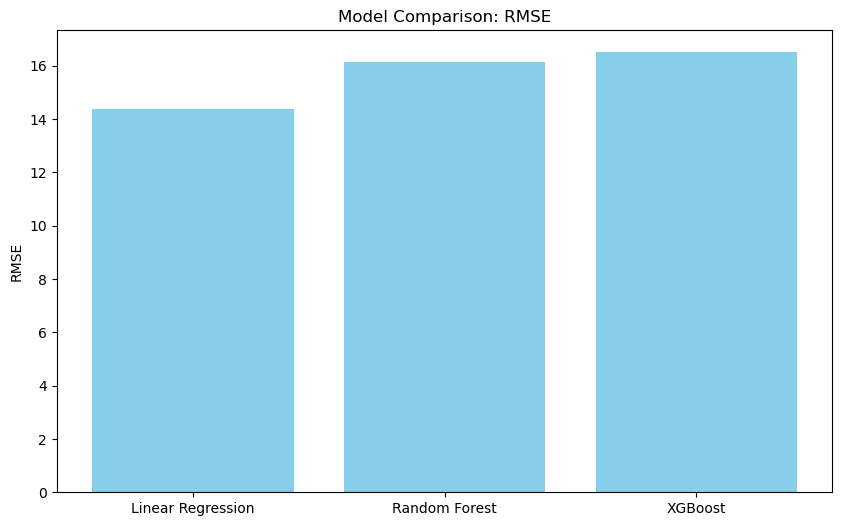

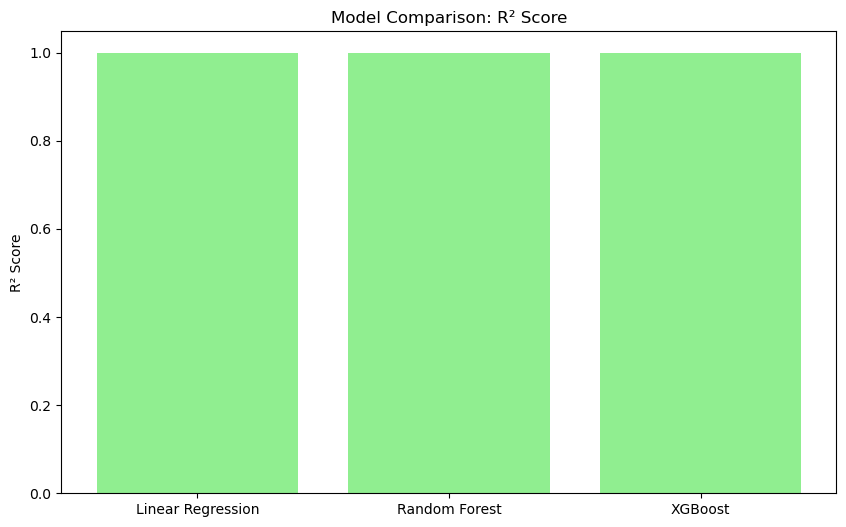

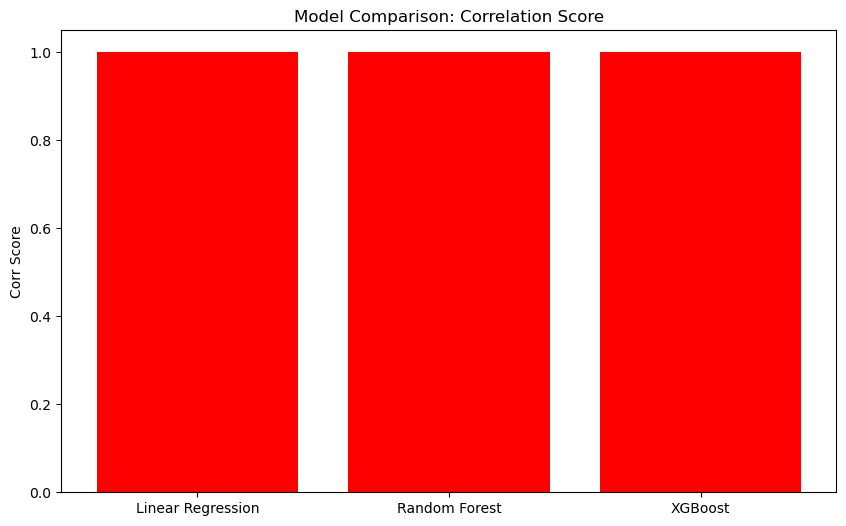

In [121]:
models = list(test_results.keys())
rmse_values = [test_results[model]['RMSE'] for model in models]
r2_values = [test_results[model]['R2'] for model in models]
corr_values = [test_results[model]['corr'] for model in models]

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='skyblue')
plt.title('Model Comparison: RMSE')
plt.ylabel('RMSE')
plt.show()

# Plot R²
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='lightgreen')
plt.title('Model Comparison: R² Score')
plt.ylabel('R² Score')
plt.show()

# Plot Corr
plt.figure(figsize=(10, 6))
plt.bar(models, corr_values, color='red')
plt.title('Model Comparison: Correlation Score')
plt.ylabel('Corr Score')
plt.show()

### Visualization: 
Ploting the actual gold price against the predicted gold price

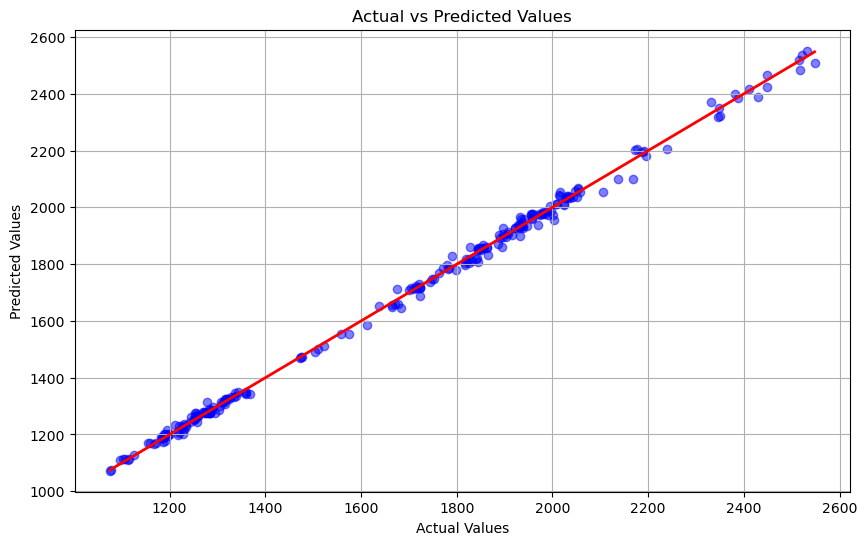

In [123]:
# Create a scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # line of perfect prediction
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


* The red line represents the perfect predictions where the actual and predicted values would be exactly equal. The closer the points are to the red line, the better the predictions.
* From the above visual, there is a close relationship between the predicted value and the actual value

#### Residual Ploting:
* To see how well the model is doing in terms of errors (residuals), below is the plot for the residuals (the difference between the actual and predicted values).
* Residual plot help to visualize any patterns in the residuals, which can indicate model improvement areas. If the residuals are randomly scattered around zero, the model is likely performing well.

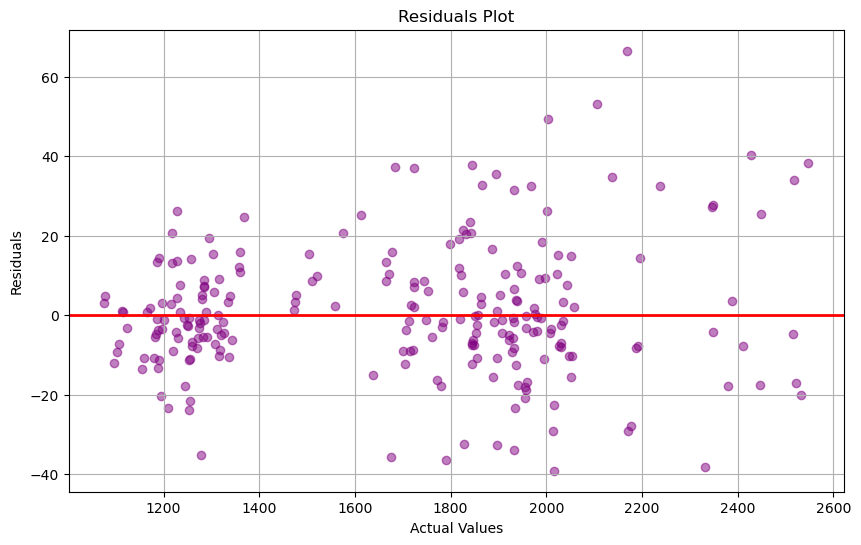

In [126]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='red', linewidth=2)
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


### Observation
* From the above residual ploting, we can see that there are still room for improvement for this predictive model
* I will proceed and add other economical variables to the fearture and see if it will improve the model performance. 

#### Feature importance


In [129]:
coefficients = best_models['Linear Regression'].coef_

# Create a DataFrame for coefficients with feature names
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

In [130]:
coeff_df

,Feature,Coefficient
0,sentiment_score,4.646893
1,usd_rate,-1.380868
2,oil_price,-8.703383
3,bond_yield_price,-7.214511
4,interest_rate,5.811237
5,inflation_rate,14.347167
6,gold_price,1543.591137


In [131]:
# I will exclude the historical gold price influence on the prediction to have a good visuals of others with low values
coeff_df.iloc[:6]['Feature']

0     sentiment_score
1            usd_rate
2           oil_price
3    bond_yield_price
4       interest_rate
5      inflation_rate
Name: Feature, dtype: object

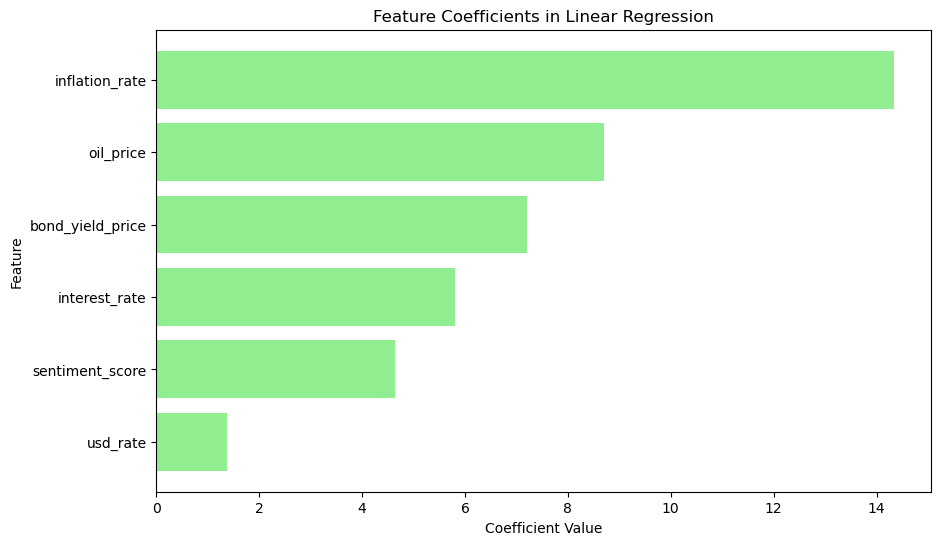

In [132]:
# Get feature coefficients
feature_names = coeff_df.iloc[:6]['Feature']
coefficients = coeff_df.iloc[:6]['Coefficient']
# Create a DataFrame to visualize
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance_df['abs_coeff'] = np.abs(importance_df['Coefficient'])  # for better sorting
importance_df = importance_df.sort_values(by='abs_coeff', ascending=False)

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['abs_coeff'], color='lightgreen')
plt.title('Feature Coefficients in Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


### Table view of the actual gold price and the predicted price

In [134]:
# Create a DataFrame to compare actual vs predicted
comparison_df = pd.DataFrame({'Gold Actual Price': y_test, 'Gold Predicted Price': y_pred})   #  y_pred_lr
comparison_df['diff'] = comparison_df['Gold Predicted Price']-comparison_df['Gold Actual Price'] 
comparison_df.head(10)

,Gold Actual Price,Gold Predicted Price,diff
506,1816.7,1804.782959,-11.917041
220,1234.0,1233.343628,-0.656372
1043,2171.6,2200.775879,29.175879
977,2014.5,2043.719482,29.219482
174,1273.1,1276.349487,3.249487
584,1844.4,1852.005859,7.605859
786,1862.5,1859.647583,-2.852417
1139,2447.3,2464.818359,17.518359
58,1159.2,1169.958618,10.758618
240,1243.5,1244.313599,0.813599


In [135]:
price_dif = comparison_df['diff']
print(f'Maximum price diff : {price_dif.max()}')
print(f'Minimum price diff: {price_dif.min()}')
print(f'Average price diff: {price_dif.mean()}')

Maximum price diff : 39.159228515625045
Minimum price diff: -66.5048828125
Average price diff: -0.7778297456781884
